In [1]:
import numpy as np
import scipy
from scipy import stats

import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools 
from statsmodels.tsa.stattools import adfuller

import requests
from io import BytesIO
from pandas_datareader.data import DataReader
import pandas_datareader.data as web

from datetime import datetime


import xlsxwriter

import numpy as np
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.axes

import os
import sys
import scipy.stats as scs


C:\Users\Dell\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [57]:
usrec = DataReader('USREC', 'fred', start=datetime(1999, 1, 29), end=datetime(2017, 8, 31))

In [58]:
writer1 = pd.ExcelWriter('USREC.xlsx', engine='xlsxwriter')
   
usrec.to_excel(writer1, 'Sheet1')

writer1.save()


In [59]:
USREC = pd.read_excel('USREC.xlsx')

In [61]:
USREC.set_index(USREC['DATE'], inplace=True)
USREC.set_index('DATE', inplace=True)

In [36]:
Canada = pd.read_excel('Canada.xlsx')

In [37]:
Canada.set_index(Canada['Date'], inplace=True)
Canada.set_index('Date', inplace=True)

In [38]:
dateparse = lambda Canada: pd.to_datetime(Canada, format='%m%d%Y')

In [39]:
print Canada.head()


             Canada
Date               
1/29/1999  0.075447
2/26/1999 -0.061780
3/31/1999  0.038409
4/30/1999  0.091312
5/28/1999 -0.032836


In [13]:
Canada['rol_mean'] = Canada['Canada'].rolling(window=60, center=False).mean() 
Canada['rol_std'] = Canada["Canada"].rolling(window=60,center=False).std()

In [14]:
rol_mean = Canada['Canada'].rolling(window=60, center=False).mean() 
rol_std = Canada["Canada"].rolling(window=60,center=False).std()

In [15]:
def tsplot(y, lags=None, figsize=(18, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

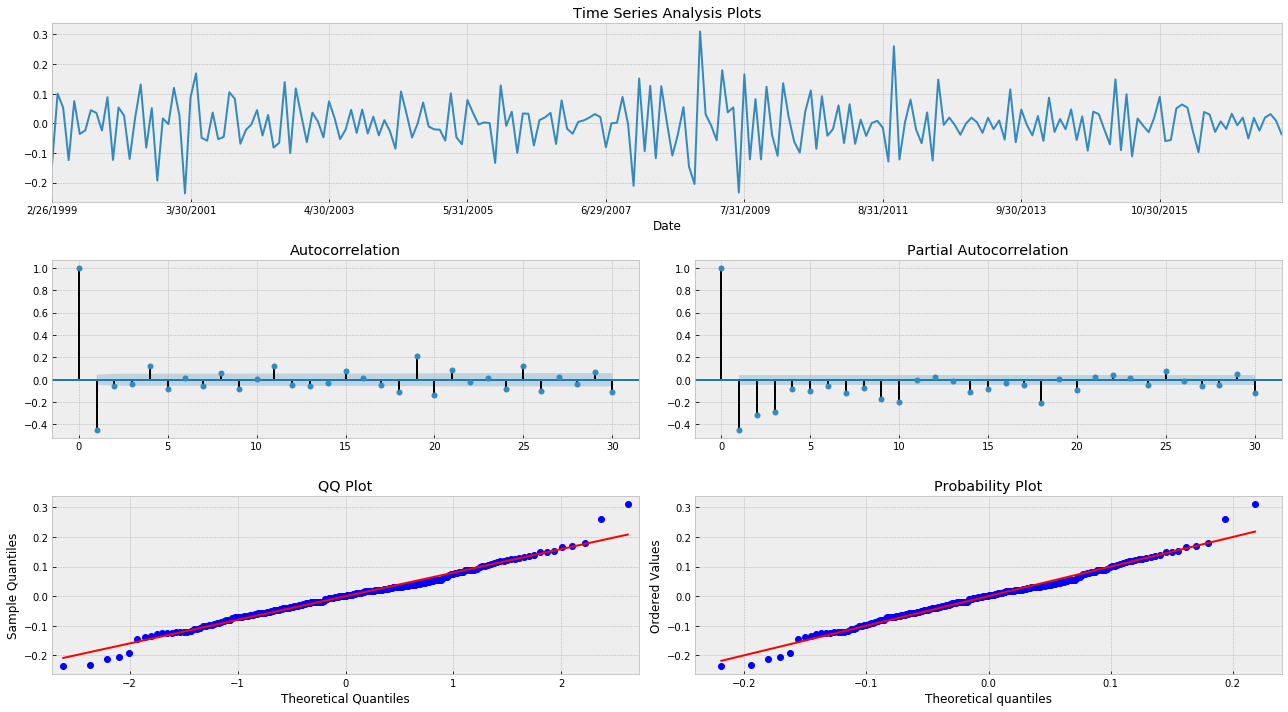

In [50]:
_ = tsplot(RMC["Canada"], lags=30)

In [17]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [18]:
test_stationarity(Canada["Canada"])

Results of Dickey-Fuller Test:
Test Statistic                -1.286037e+01
p-value                        5.125757e-24
#Lags Used                     0.000000e+00
Number of Observations Used    2.230000e+02
Critical Value (5%)           -2.874590e+00
Critical Value (1%)           -3.460019e+00
Critical Value (10%)          -2.573725e+00
dtype: float64


In [43]:
diff=Canada.diff()
diff=diff.dropna()

In [45]:
writer1 = pd.ExcelWriter('RMC.xlsx', engine='xlsxwriter')
   
diff.to_excel(writer1, 'Sheet1')

writer1.save()


In [46]:
RMC = pd.read_excel('RMC.xlsx')

In [47]:
RMC.set_index(RMC['Date'], inplace=True)
RMC.set_index('Date', inplace=True)

In [48]:
test_stationarity(RMC["Canada"])

Results of Dickey-Fuller Test:
Test Statistic                -8.639658e+00
p-value                        5.469600e-14
#Lags Used                     9.000000e+00
Number of Observations Used    2.130000e+02
Critical Value (5%)           -2.875207e+00
Critical Value (1%)           -3.461429e+00
Critical Value (10%)          -2.574054e+00
dtype: float64


In [56]:
mod3 = sm.tsa.MarkovAutoregression(RMC["Canada"], k_regimes=2, order=3, switching_ar=False)
res3 = mod3.fit()
print (res3.summary())

                         Markov Switching Model Results                         
Dep. Variable:                   Canada   No. Observations:                  220
Model:             MarkovAutoregression   Log Likelihood                 291.284
Date:                  Sun, 26 Nov 2017   AIC                           -566.567
Time:                          20:29:44   BIC                           -539.418
Sample:                      05-28-1999   HQIC                          -555.604
                           - 08-31-2017                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.011     -0.012      0.990      -0.022       0.022
                             Regime 

In [62]:
print(res3.expected_durations)

[ 2.00007418  1.99990114]


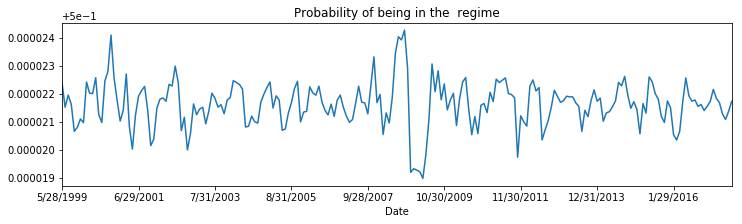

In [63]:
res3.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in the  regime', figsize=(12,3))

In [71]:
mod4 = sm.tsa.MarkovAutoregression(RMC["Canada"], k_regimes=2, order=3, switching_ar=True)
res4 = mod4.fit()
print (res4.summary())

                         Markov Switching Model Results                         
Dep. Variable:                   Canada   No. Observations:                  220
Model:             MarkovAutoregression   Log Likelihood                 303.259
Date:                  Sun, 26 Nov 2017   AIC                           -584.518
Time:                          20:40:46   BIC                           -547.188
Sample:                      05-28-1999   HQIC                          -569.443
                           - 08-31-2017                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0097      0.006     -1.673      0.094      -0.021       0.002
ar.L1         -0.3242      0.111    

In [70]:
#This model demonstrates estimation with regime heteroskedasticity (switching of variances) and no mean effect. 

mod_kns = sm.tsa.MarkovRegression(RMC["Canada"], k_regimes=2, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
print(res_kns.summary())

                        Markov Switching Model Results                        
Dep. Variable:                 Canada   No. Observations:                  223
Model:               MarkovRegression   Log Likelihood                 262.354
Date:                Sun, 26 Nov 2017   AIC                           -516.708
Time:                        20:40:09   BIC                           -503.079
Sample:                    02-26-1999   HQIC                          -511.206
                         - 08-31-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0026      0.001      2.839      0.005       0.001       0.004
                             Regime 1 parameters    

In [68]:
#Filardo (1994) Time-Varying Transition Probabilities

In [150]:
f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m
start = pd.to_datetime('1999-01-29')
end = pd.datetime.today()
data = (web.DataReader([f1, f2, f3], 'fred', start, end))

In [151]:
writer = pd.ExcelWriter('TED.xlsx', engine='xlsxwriter')
   
data.to_excel(writer, 'Sheet1')

writer.save()

In [175]:
FED = pd.read_excel('TED.xlsx')

In [176]:
FED.set_index(FED['DATE'], inplace=True)
FED.set_index('DATE', inplace=True)

In [177]:
print FED.head()

            T10Y3M
DATE              
1999-01-29    0.18
1999-02-26    0.63
1999-03-31    0.76
1999-04-30    0.81
1999-05-31    0.81
